# MINST 数据集上的手写数字识别

环境描述：

1. torch 1.31.1
3. torchvision 0.14.1

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

%matplotlib inline

In [2]:
# 迭代次数
n_epochs = 10
# 训练集的 batch size
batch_size_train = 64
# 测试集的 batch size
batch_size_test = 1000
# 下面两个是超参数
learning_rate = 0.01
momentum = 0.5
log_interval = 10

# 可重复使用，需要设置 seed
random_seed = 1
torch.manual_seed(random_seed)

In [3]:
# 下载 MINST 数据集，到 ../data 目录中
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data/', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ])),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('../data/', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.1307,), (0.3081,))
    ])),
    batch_size=batch_size_test, shuffle=True)

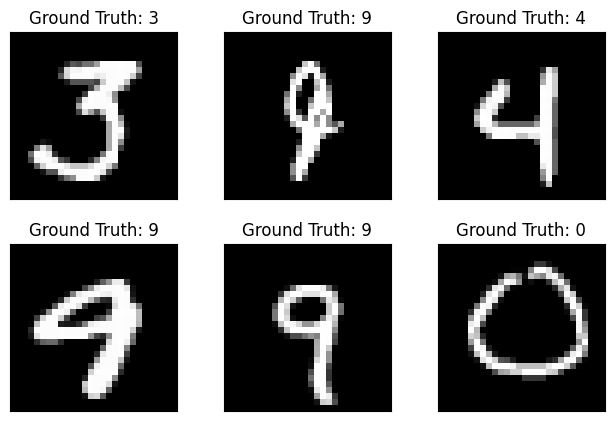

In [4]:
# 使用 matplotlib 来绘制一些(测试数据, 测试标签)看一下
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## 搭建 CNN

CNN 的大概结构如下所述：

1. 两个2d卷积层
2. 两个全连接(或线性)层
3. 激活函数：ReLU，
4. 正则化：一个 dropout 层。
5. 在PyTorch中，构建网络的一个好方法是为我们希望构建的网络创建一个 `class` 。让我们在这里导入一些子模块，以获得更具可读性的代码。

In [5]:
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim


# 搭建 CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 构建 CNN 中的相关层，包括两个 2d 卷积层、一个 dropout 层、两个全连接层
        # 最后的输出是一个十维向量，代表 [1, 10]，通过 softmax 来变化为一个和为 1 的向量，其中值最大的就是我们识别的结果
        # 比如经过 softmax 的向量为 [0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2]。则识别结果为 9
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # 通过 max_pool + relu 来进行矩阵经过神经网络的变化
        # max_pool 的 size 是 2
        x = func.relu(func.max_pool2d(self.conv1(x), 2))
        x = func.relu(func.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # reshape 为 320，对应后面的全连接层
        x = x.view(-1, 320)
        x = func.relu(self.fc1(x))
        x = func.dropout(x, training=self.training)
        x = self.fc2(x)
        return func.log_softmax(x, dim=1)

In [6]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [7]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

In [8]:
# 通过训练数据集进行训练
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = func.nll_loss(output, target)
        # 反向传播计算损失函数
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
            # 保存当前训练的模型
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')

In [9]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            # 计算测试的损失函数
            test_loss += func.nll_loss(output, target, reduction='sum').item()
            # 预测结果其实就是 soft_max 中值最大的那个下标
            pred = output.data.max(1, keepdim=True)[1]
            # 计算正确率
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct,
                                                                              len(test_loader.dataset),
                                                                              100. * correct / len(
                                                                                  test_loader.dataset)))


Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325928
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.287777
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281435
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.243744
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.264606
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.240564
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153203
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.211479
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.056642
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.010620
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.008978
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.867196
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.755030
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.617570
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.411560
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.595002
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.259322
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.326811
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.236616
Train Epoch: 1 [12160/6

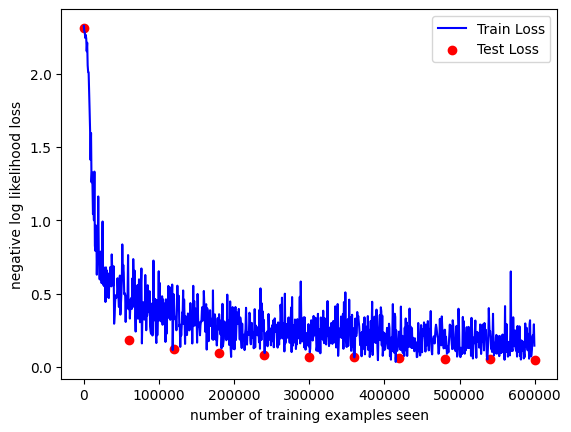

In [10]:
# 实际的过程，这里先 test() 是因为没有这个绘图的时候会报错
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

## 模型结果展示

上面的迭代可以看出，其实在第五次迭代之后，准确率基本就在 98%，后面的迭代可能会造成模型的过拟合。下面可以随便选几张测试集的照片进行预测，可以看到基本能够预测出 MINST 中的手写数字

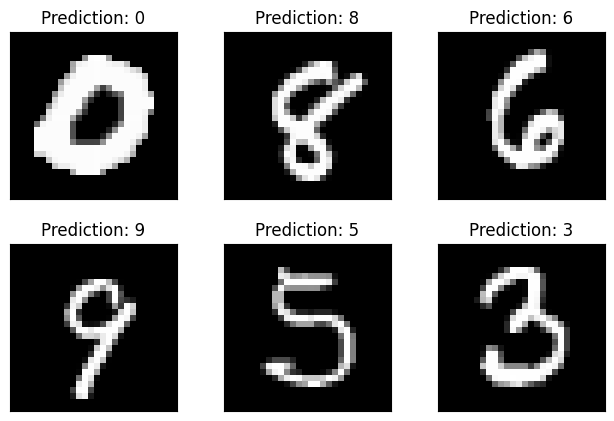

In [12]:
# 下面是使用 model 来对测试数据进行可视化的预测
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
    output = network(example_data)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(
        output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()